In [1]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
import os
import warnings 
warnings.filterwarnings('ignore')


def load_data(file_name, data_folder='data', year=None):
    """
    Load a CSV file with a specified header row, handling encoding issues.

    Parameters:
    - file_name: Name of the file to be loaded.
    - data_folder: Folder where the data files are stored.
    - year: Year of the file being loaded (used to determine header)

    Returns:
    - A pandas DataFrame containing the loaded data.
    """
    file_path = os.path.join(data_folder, file_name)
    
    # Determine the header row based on the year
    header_row = 7 # default 
    if year in [2017, 2018]:
        header_row = 8 
    try:
        df = pd.read_csv(file_path, encoding='ISO-8859-1', sep=',', header=header_row)
    except Exception as e:
        raise Exception(f"Error loading {file_name}: {str(e)}")
   
    return df

def clean_data(df):
    """
    Clean the DataFrame by dropping empty columns, removing
    rows with N/A data, and formatting the 'Characteristic' column.

    Parameters:
    - df: The DataFrame to be cleaned.
    -drop_columns: List of column names to drop

    Returns:
    - A cleaned pandas DataFrame.
    """
    # Drop columns that contain only NaN values and rows with any N/A data
    df_cleaned = df.dropna(axis=1, how='all').dropna()
    # Cleaning characteristics column 
    df_cleaned["Characteristic"] = df_cleaned["Characteristic"].str.replace(".",
                                                                             "", 
                                                                             regex=False)
    # Dropping Unnamed columns 
    df_cleaned = df_cleaned.drop([col for col in df.columns if 'Unnamed' in col], axis=1,
                                errors='ignore')
    
    return df_cleaned

def process_all_files(years, data_folder='data'):
    """
    Load and clean all specified data files.

    Parameters:
    - years: A list of years for which data files should be processed.
    - data_folder: Folder where the data files are stored.

    Returns:
    - A dictionary of cleaned DataFrames for each year.
    """
    dfs = {}
    # Stores cleaned dataframes into a dfs dictionary 
    for year in years:
        file_name = f"Household_income_{year}.csv"
        df = load_data(file_name, data_folder, year=year)
        # Sets the year
        df_cleaned = clean_data(df)
        dfs[year] = df_cleaned
    
    return dfs

In [2]:
years = list(range(2013,2023))
dataframes = process_all_files(years)
df2022 = dataframes[2022]
df2022

,Characteristic,Total,"Under $5,000","$5,000 to $9,999","$10,000 to $14,999","$15,000 to $19,999","$20,000 to $24,999","$25,000 to $29,999","$30,000 to $34,999","$35,000 to $39,999",...,"$175,000 to $179,999","$180,000 to $184,999","$185,000 to $189,999","$190,000 to $194,999","$195,000 to $199,999","$200,000 and over",Median income,Mean income,Gini ratio,Income per household member
1,All households,"131,400","4,305","2,131","4,536","4,725","5,047","4,728","5,285","4,674",...,"1,043","1,106",921.0,940.0,889.0,"15,660","74,580","106,400",0.488,"42,330"
3,Inside metropolitan statistical areas,"113,500","3,647","1,714","3,734","3,850","4,082","3,794","4,327","3,788",...,975,"1,022",874.0,881.0,831.0,"14,740","77,500","110,900",0.486,"43,860"
4,Inside principal cities,"43,710","1,731",798,"1,835","1,744","1,736","1,620","1,870","1,660",...,267,338,270.0,247.0,249.0,"5,054","69,940","102,900",0.506,"43,250"
5,Outside principal cities,"69,770","1,916",916,"1,899","2,106","2,346","2,174","2,458","2,128",...,707,684,603.0,634.0,582.0,"9,683","83,230","115,900",0.473,"44,210"
6,Outside metropolitan statistical areas,"17,950",659,417,801,875,965,934,957,885,...,68,83,47.0,59.0,58.0,922,"55,960","77,930",0.472,"32,190"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,Professional degree,"2,135",35,20,11,24,44,37,27,45,...,26,37,17.0,15.0,40.0,816,"157,800","209,100",0.463,"86,510"
82,Doctorate degree,"2,919",53,30,11,30,31,46,17,39,...,38,47,53.0,38.0,33.0,"1,047","151,400","203,000",0.437,"80,470"
84,Owner occupied,"86,780","2,090",905,"1,852","2,292","2,523","2,672","2,732","2,617",...,918,884,755.0,797.0,773.0,"13,460","90,630","123,800",0.466,"47,100"
85,Renter occupied,"43,260","2,088","1,149","2,598","2,313","2,422","1,980","2,451","2,023",...,125,212,158.0,143.0,116.0,"2,141","51,730","72,900",0.488,"31,720"


In [176]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def perform_linear_regression(X, y):
    '''
    Performs linear regression on the provided data and returns the
    model, predicted values, and R2 values.
       
    Parameters: 
    - X: independent variable
    - y: dependent variable
       
    Returns: 
    - model: the fitted LinearRegression model
    - y_pred = the predicted values based on the model
    - r2 = R2 value indicating goodness of fit.
    '''
    model = LinearRegression()
    model.fit(X, y)
    # Predict values and calculate r2
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    return model, y_pred, r2

def income_by_degree(df, degree_type):
    '''Extracts the average household income for specified
    degrees from the DataFrame.
    
    Parameters:
    - df: the DataFrame to extract data from
    - degree_type: list of keywords to identify degree rows
    
    Returns: 
    - Dictionary with the degree type as keys and avg hosuehold
    income as values.
    '''
    df.columns = df.columns.str.strip()
    income_data = {}
    for keyword in degree_type: 
        # identify row that contains degree information
        degree_row = df[df['Characteristic'].str.contains(keyword,
                                                         case=False,
                                                         na=False)]
        # Extracting mean income for the degree
        income = degree_row['Mean income'].values[0]
        income_data[keyword] = float(income.replace(',',''))
        
    return income_data 

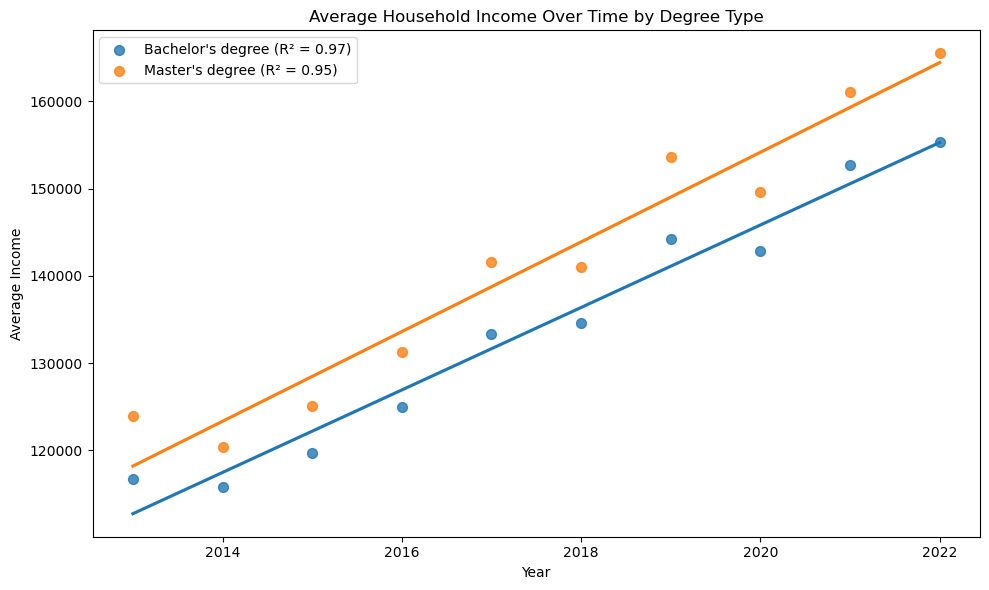

In [177]:
def prepare_plot_data(dataframes, degree_type):
    ''' 
    Prepares data for the heatmap showing average income over time
    by degree type.
    
    Parameters:
    - dataframes: Dictionary of DataFrames for each year
    - degree_type: list of keywords to identify degree rows
    
    Returns:
    - A pivot table DataFrame for heatmap plotting.'''
    income_data = []
    
    for year, df, in dataframes.items():
        degree_incomes = income_by_degree(df, degree_type)
        for degree, income in degree_incomes.items():
            income_data.append({
                'Year': year, 
                'Degree': degree,
                'Average Income': income
            })
    
    income_df = pd.DataFrame(income_data)
    heatmap_data = income_df.pivot(index="Degree", columns="Year", 
                                   values='Average Income')
    
    return income_df, heatmap_data    
    
def plot_degree_trends(income_df):
    '''Plots average household income trends over time with linear 
    regression, including r2 value on the plot.'''
    plt.figure(figsize=(10,6))
    degree_types = income_df['Degree'].unique()
    
    for degree in degree_types: 
        # Filter the data for the current degree
        degree_data = income_df[income_df['Degree'] == degree]
        # Preparing data for linear regression 
        X = degree_data['Year'].values.reshape(-1, 1)
        y = degree_data['Average Income'].values
        # Perform linear regression
        model, y_pred, r2 = perform_linear_regression(X, y)
        # Plot data and regression line
        sns.regplot(x='Year', y='Average Income', data=degree_data, 
                   label=f'{degree} (R² = {r2:.2f})', ci=None, 
                    scatter_kws={"s": 50})
    
    plt.xlabel('Year')
    plt.ylabel('Average Income')
    plt.title('Average Household Income Over Time by Degree Type')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

degree_type = ["Bachelor's degree", "Master's degree"]
income_df, heatmap_data = prepare_plot_data(dataframes, degree_type)
# Linear regression
plot_degree_trends(income_df)

- both degree types show a clear upward trend in income over time
- r2 values for both Bachelor's degree(0.97) and Master's degree(0.95) indicates a consistent strong trend 

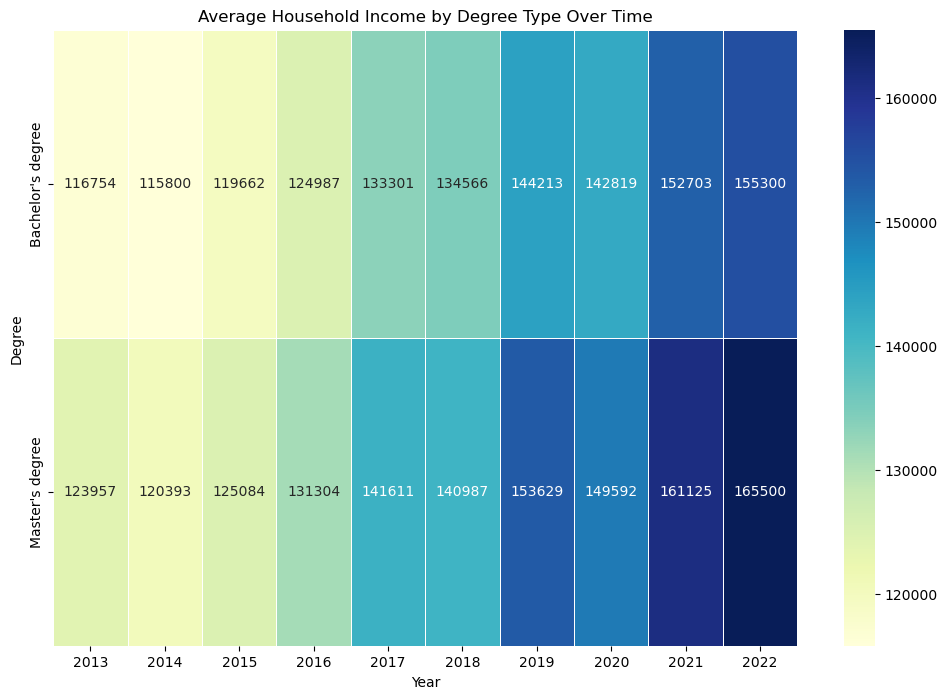

In [178]:
def plot_heatmap(heatmap_data):
    '''Plots a heatmap for the average household income by degree type 
    over time.
    
    Parameters:
    - heatmap_data: Pivot table DataFrame with degrees as rows, years as
    cols, and avg income as values
    '''
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGnBu', 
               linewidths=.5)
    plt.title("Average Household Income by Degree Type Over Time")
    plt.show()
    
# Heatmap
degree_type = ["Bachelor's degree", "Master's degree"]
income_df, heatmap_data = prepare_plot_data(dataframes, degree_type)
plot_heatmap(heatmap_data)

- heatmap reveals a general trend of increasing average income over time 
- Master's degree holders consistenly have higher average incomes compared to Bachelor's degree holders 
- The income gap between the tep degrees appears to widen over time over the years, indicated by the deeper color gradients for Master's degrees 

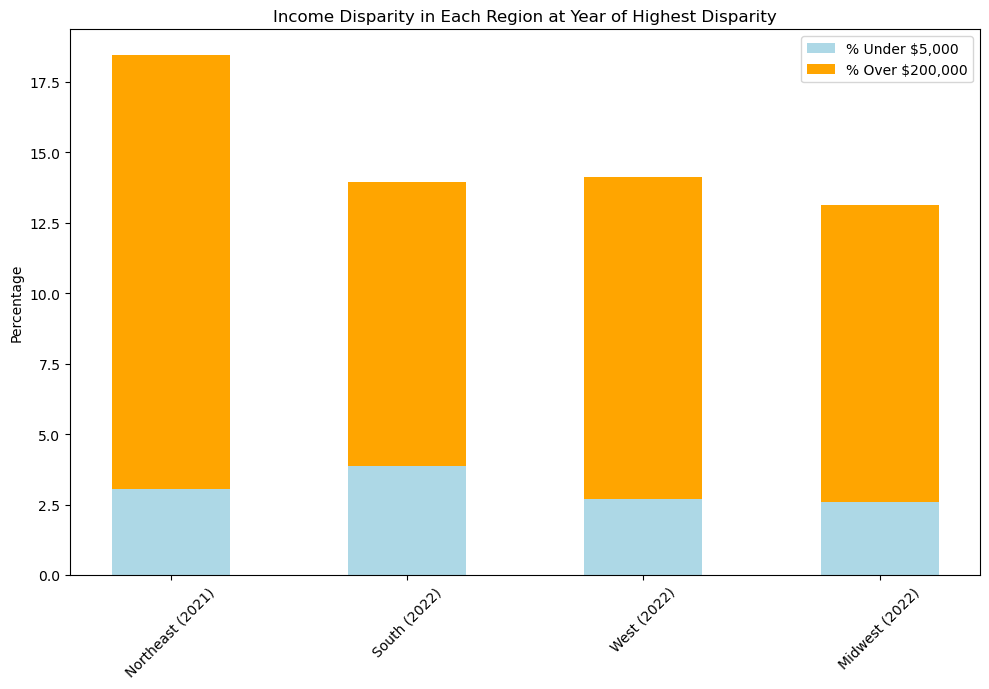

In [179]:
def calculate_disparity(df):
    '''
    Calculates the % of households earning under $5k and over $200k,
    then computes the disparity.
    
    Parameters: 
    - df: DataFrame containing income data
    
    Returns: 
    - df: DataFrame with additional columns for percentage calculations
    '''
    # Clean data for calculations
    for col in ['Under $5,000', '$200,000 and over', 'Total']:
        if df[col].dtype == 'object':
            df.loc[:, col] = df[col].str.replace(',', '').astype(float)
    # Adding columns 
    df.loc[:, '% Under $5,000'] = (df['Under $5,000'] / df['Total']) * 100
    df.loc[:, '% Over $200,000'] = (df['$200,000 and over'] / df['Total']) * 100
    # Calculate disparity
    df.loc[:, 'Disparity'] = df['% Over $200,000'] - df['% Under $5,000']
    
    return df

def find_highest_disparity_year(dataframes, region):
    '''
    Finds the year with the highest disparity for a specific
    region.
    
    Parameters: 
    - dataframes: Dictionary of DataFrames identified by year
    - region: the region name to search for 
    
    Returns:
    - max_year: the year with the highest disparity
    - max_disparity: the highest disparity value 
    - max_df: the DataFrame of the region for the year with highest disparity.
    '''
    max_disparity = -float('inf')
    max_year = None
    max_df = None
    # Looping through each year's dataframe
    for year, df in dataframes.items():
        region_df = df[df['Characteristic'].str.contains(region)]
        # Calculating disparity for each region
        region_disparity = calculate_disparity(region_df)
        current_disparity = region_disparity['Disparity'].max()
        # Updating max values
        if current_disparity > max_disparity:
            max_disparity = current_disparity
            max_year = year
            max_df = region_disparity
    
    return max_year, max_disparity, max_df

def plot_stacked_bar(dataframes, regions):
    '''
    Plots a stacked bar chart comparing % under $5k and % over
    $200k at each region's highest year of disparity.
    
    Parameters: 
    - dataframes: dictionary of DataFrames identified by year
    - regions: list of regions to include in the plot
    '''
    under_5k = []
    over_200k = []
    region_year_labels = []
    # Looping through each region to find year
    for region in regions:
        max_year, max_disparity, region_df = find_highest_disparity_year(dataframes, region)
        # Appending values 
        region_year_labels.append(f"{region} ({max_year})")
        under_5k.append(region_df['% Under $5,000'].values[0])
        over_200k.append(region_df['% Over $200,000'].values[0])
    # Plotting stacked bar chart
    bar_width = 0.5
    fig, ax = plt.subplots(figsize=(10, 7))
    # Plot the bars
    p1 = ax.bar(region_year_labels, under_5k, bar_width, label='% Under $5,000', color='lightblue')
    p2 = ax.bar(region_year_labels, over_200k, bar_width, bottom=under_5k, label='% Over $200,000', color='orange')
    # Labels and title
    ax.set_ylabel('Percentage')
    ax.set_title('Income Disparity in Each Region at Year of Highest Disparity')
    ax.legend()
    # Show the plot
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
regions = ["Northeast", "South", "West", "Midwest"]
plot_stacked_bar(dataframes, regions)

- Northeast(2021) exhibits the highest disparity among the regions, with around 17.5% of households earning over 200,000 and 2.5% under 5,000
- South, West, and Midwest (2022) had the highest disparity in the same year, with around 12-15% of households on the higher end and 2-3% on the lower end 
- While all regions have notable income disparity, the northeast stands out with the most siginificant gap between the wealthiest and poorest households 

In [86]:
def plot_income_brackets(dataframes, year, age_start_row, age_end_row):
    """
    Plots income distribution by specified income brackets for a given year.

    Parameters:
    - dataframes: Dictionary of DataFrames identified by year.
    - year: The year for which to plot income distribution.
    - age_start_row: Starting row index for age data.
    - age_end_row: Ending row index for age data.
    """
    df = dataframes[year]
    # Select specified rows for age data
    age_data = df.iloc[age_start_row:age_end_row]

    # Define the income brackets
    brackets = {
        'Below $50,000': ['Under $5,000', '$5,000 to $9,999', '$10,000 to $14,999', '$15,000 to $19,999', '$20,000 to $24,999', 
                          '$25,000 to $29,999', '$30,000 to $34,999', '$35,000 to $39,999', '$40,000 to $44,999', '$45,000 to $49,999'],
        '$50,000-$99,999': ['$50,000 to $54,999', '$55,000 to $59,999', '$60,000 to $64,999', '$65,000 to $69,999', 
                            '$70,000 to $74,999', '$75,000 to $79,999', '$80,000 to $84,999', '$85,000 to $89,999', 
                            '$90,000 to $94,999', '$95,000 to $99,999'],
        '$100,000-$149,999': ['$100,000 to $104,999', '$105,000 to $109,999', '$110,000 to $114,999', '$115,000 to $119,999', 
                              '$120,000 to $124,999', '$125,000 to $129,999', '$130,000 to $134,999', '$135,000 to $139,999', 
                              '$140,000 to $144,999', '$145,000 to $149,999'],
        '$150,000-$200,000': ['$150,000 to $154,999', '$155,000 to $159,999', '$160,000 to $164,999', '$165,000 to $169,999', 
                              '$170,000 to $174,999', '$175,000 to $179,999', '$180,000 to $184,999', '$185,000 to $189,999', 
                              '$190,000 to $194,999', '$195,000 to $199,999'],
        'Above $200,000': ['$200,000 and over']
    }

    # Convert columns to numeric if they contain strings
    for category_list in brackets.values():
        for category in category_list:
            if category in df.columns and df[category].dtype == 'object':
                df[category] = pd.to_numeric(df[category].astype(str).str.replace(',', '').str.replace('$', '').str.strip(), errors='coerce')

    # Aggregate the income into the defined brackets
    for bracket, categories in brackets.items():
        valid_categories = [c for c in categories if c in df.columns]
        age_data[bracket] = age_data[valid_categories].sum(axis=1)

    # Select only the aggregated bracket columns
    age_data_brackets = age_data[['Characteristic'] + list(brackets.keys())]
    age_data_brackets.set_index('Characteristic', inplace=True)
    
    age_data_brackets.plot(kind='bar', stacked=True, figsize=(10, 5))
    plt.title(f'Income Distribution by Age Group in {year}')
    plt.ylabel('Number of Household(in thousands)')
    plt.xlabel('Age Groups')
    plt.xticks(rotation=45)
    plt.legend(title='Income Brackets')
    plt.tight_layout()
    plt.show()


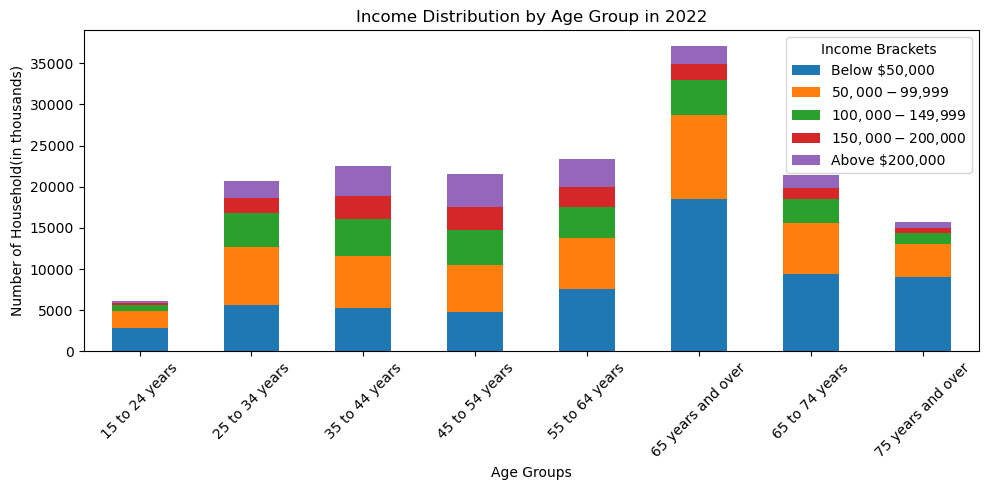

In [98]:
plot_income_brackets(dataframes, 2022, 28, 36)

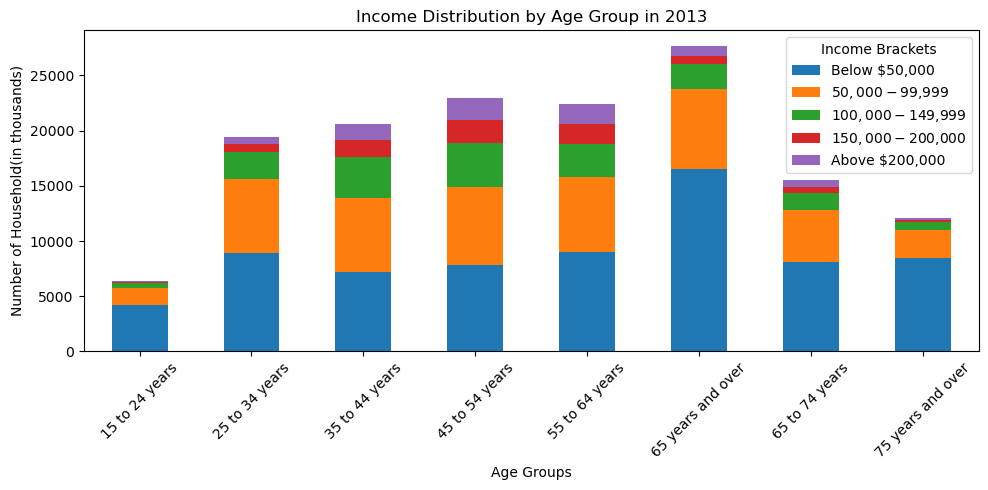

In [85]:
plot_income_brackets(dataframes, 2013, 28, 36)

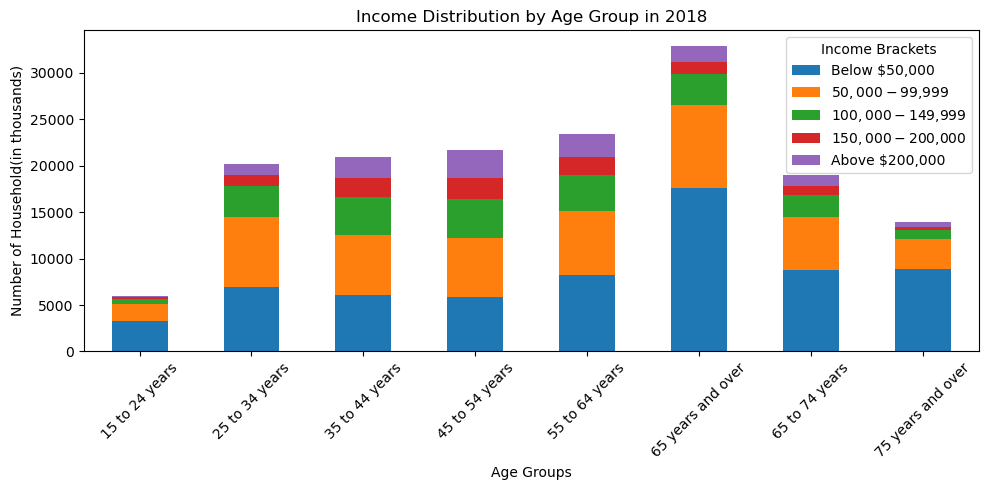

In [87]:
plot_income_brackets(dataframes, 2018, 28, 36)

In [95]:
def plot_male_vs_female_income(dataframes):
    """
    Plots male vs. female income over multiple years.

    Parameters:
    - dataframes: Dictionary of DataFrames identified by year.
    """
    income_data = []

    for year, df in dataframes.items():
        # Find rows for male and female householders
        male_row = df[df['Characteristic'].str.contains("Male householder", case=False, na=False)]
        female_row = df[df['Characteristic'].str.contains("Female householder", case=False, na=False)]

        if not male_row.empty and not female_row.empty:
            # Extract income values
            male_income_str = male_row['Mean income'].values[0]
            female_income_str = female_row['Mean income'].values[0]

            # Convert to numeric, removing any formatting
            male_income = pd.to_numeric(male_income_str.replace(',', '').replace('$', ''), errors='coerce')
            female_income = pd.to_numeric(female_income_str.replace(',', '').replace('$', ''), errors='coerce')

            # Append year and income data
            income_data.append((year, male_income, female_income))

    # Convert list to DataFrame
    income_df = pd.DataFrame(income_data, columns=['Year', 'Male Income', 'Female Income'])
    income_df.sort_values('Year', inplace=True)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(income_df['Year'], income_df['Male Income'], marker='o', label='Male Householder Income')
    plt.plot(income_df['Year'], income_df['Female Income'], marker='x', label='Female Householder Income')
    plt.title('Male vs. Female Income Over the Years')
    plt.xlabel('Year')
    plt.ylabel('Income ($)')
    plt.grid(True)
    plt.xticks(income_df['Year'], rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

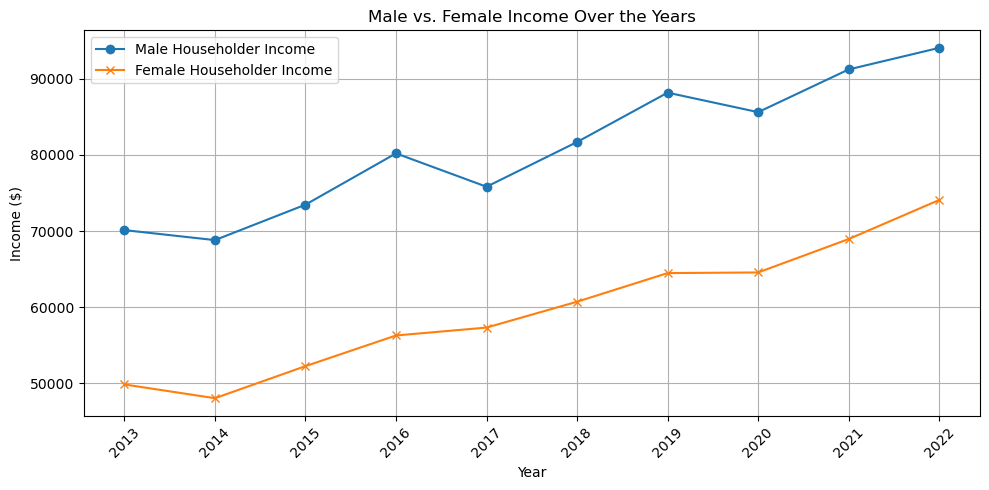

In [96]:
plot_male_vs_female_income(dataframes)

In [97]:
def plot_gender_income_gap(dataframes):
    """
    Plots the gender income gap over multiple years.

    Parameters:
    - dataframes: Dictionary of DataFrames identified by year.
    """
    gap_data = []

    for year, df in dataframes.items():
        # Ensure that data extraction and conversion is correct
        male_row = df[df['Characteristic'].str.contains("Male householder", case=False, na=False)]
        female_row = df[df['Characteristic'].str.contains("Female householder", case=False, na=False)]

        if not male_row.empty and not female_row.empty:
            try:
                # Extract mean or median income, handling possible non-numeric values
                male_income = pd.to_numeric(male_row['Mean income'].values[0].replace(',', '').replace('$', ''), errors='coerce')
                female_income = pd.to_numeric(female_row['Mean income'].values[0].replace(',', '').replace('$', ''), errors='coerce')

                if not pd.isna(male_income) and not pd.isna(female_income):
                    gap = male_income - female_income
                    # Append year and gap to the list
                    gap_data.append((year, gap))
            except Exception as e:
                print(f"Error processing year {year}: {e}")

    # Convert list to DataFrame
    gap_df = pd.DataFrame(gap_data, columns=['Year', 'Income Gap'])
    gap_df.sort_values('Year', inplace=True)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(gap_df['Year'], gap_df['Income Gap'], marker='o', label='Income Gap')
    plt.title('Gender Income Gap Over the Years')
    plt.xlabel('Year')
    plt.ylabel('Income Gap ($)')
    plt.grid(True)
    plt.xticks(gap_df['Year'], rotation=45)  # Ensure all years are shown properly
    plt.tight_layout()
    plt.legend()
    plt.show()

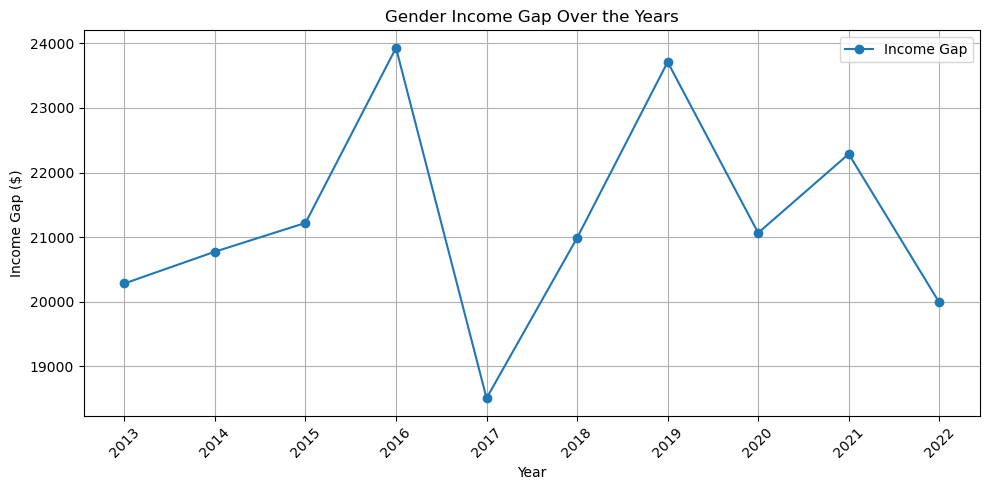

In [94]:
plot_gender_income_gap(dataframes)

In [1]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
import os
import warnings
warnings.filterwarnings('ignore')

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


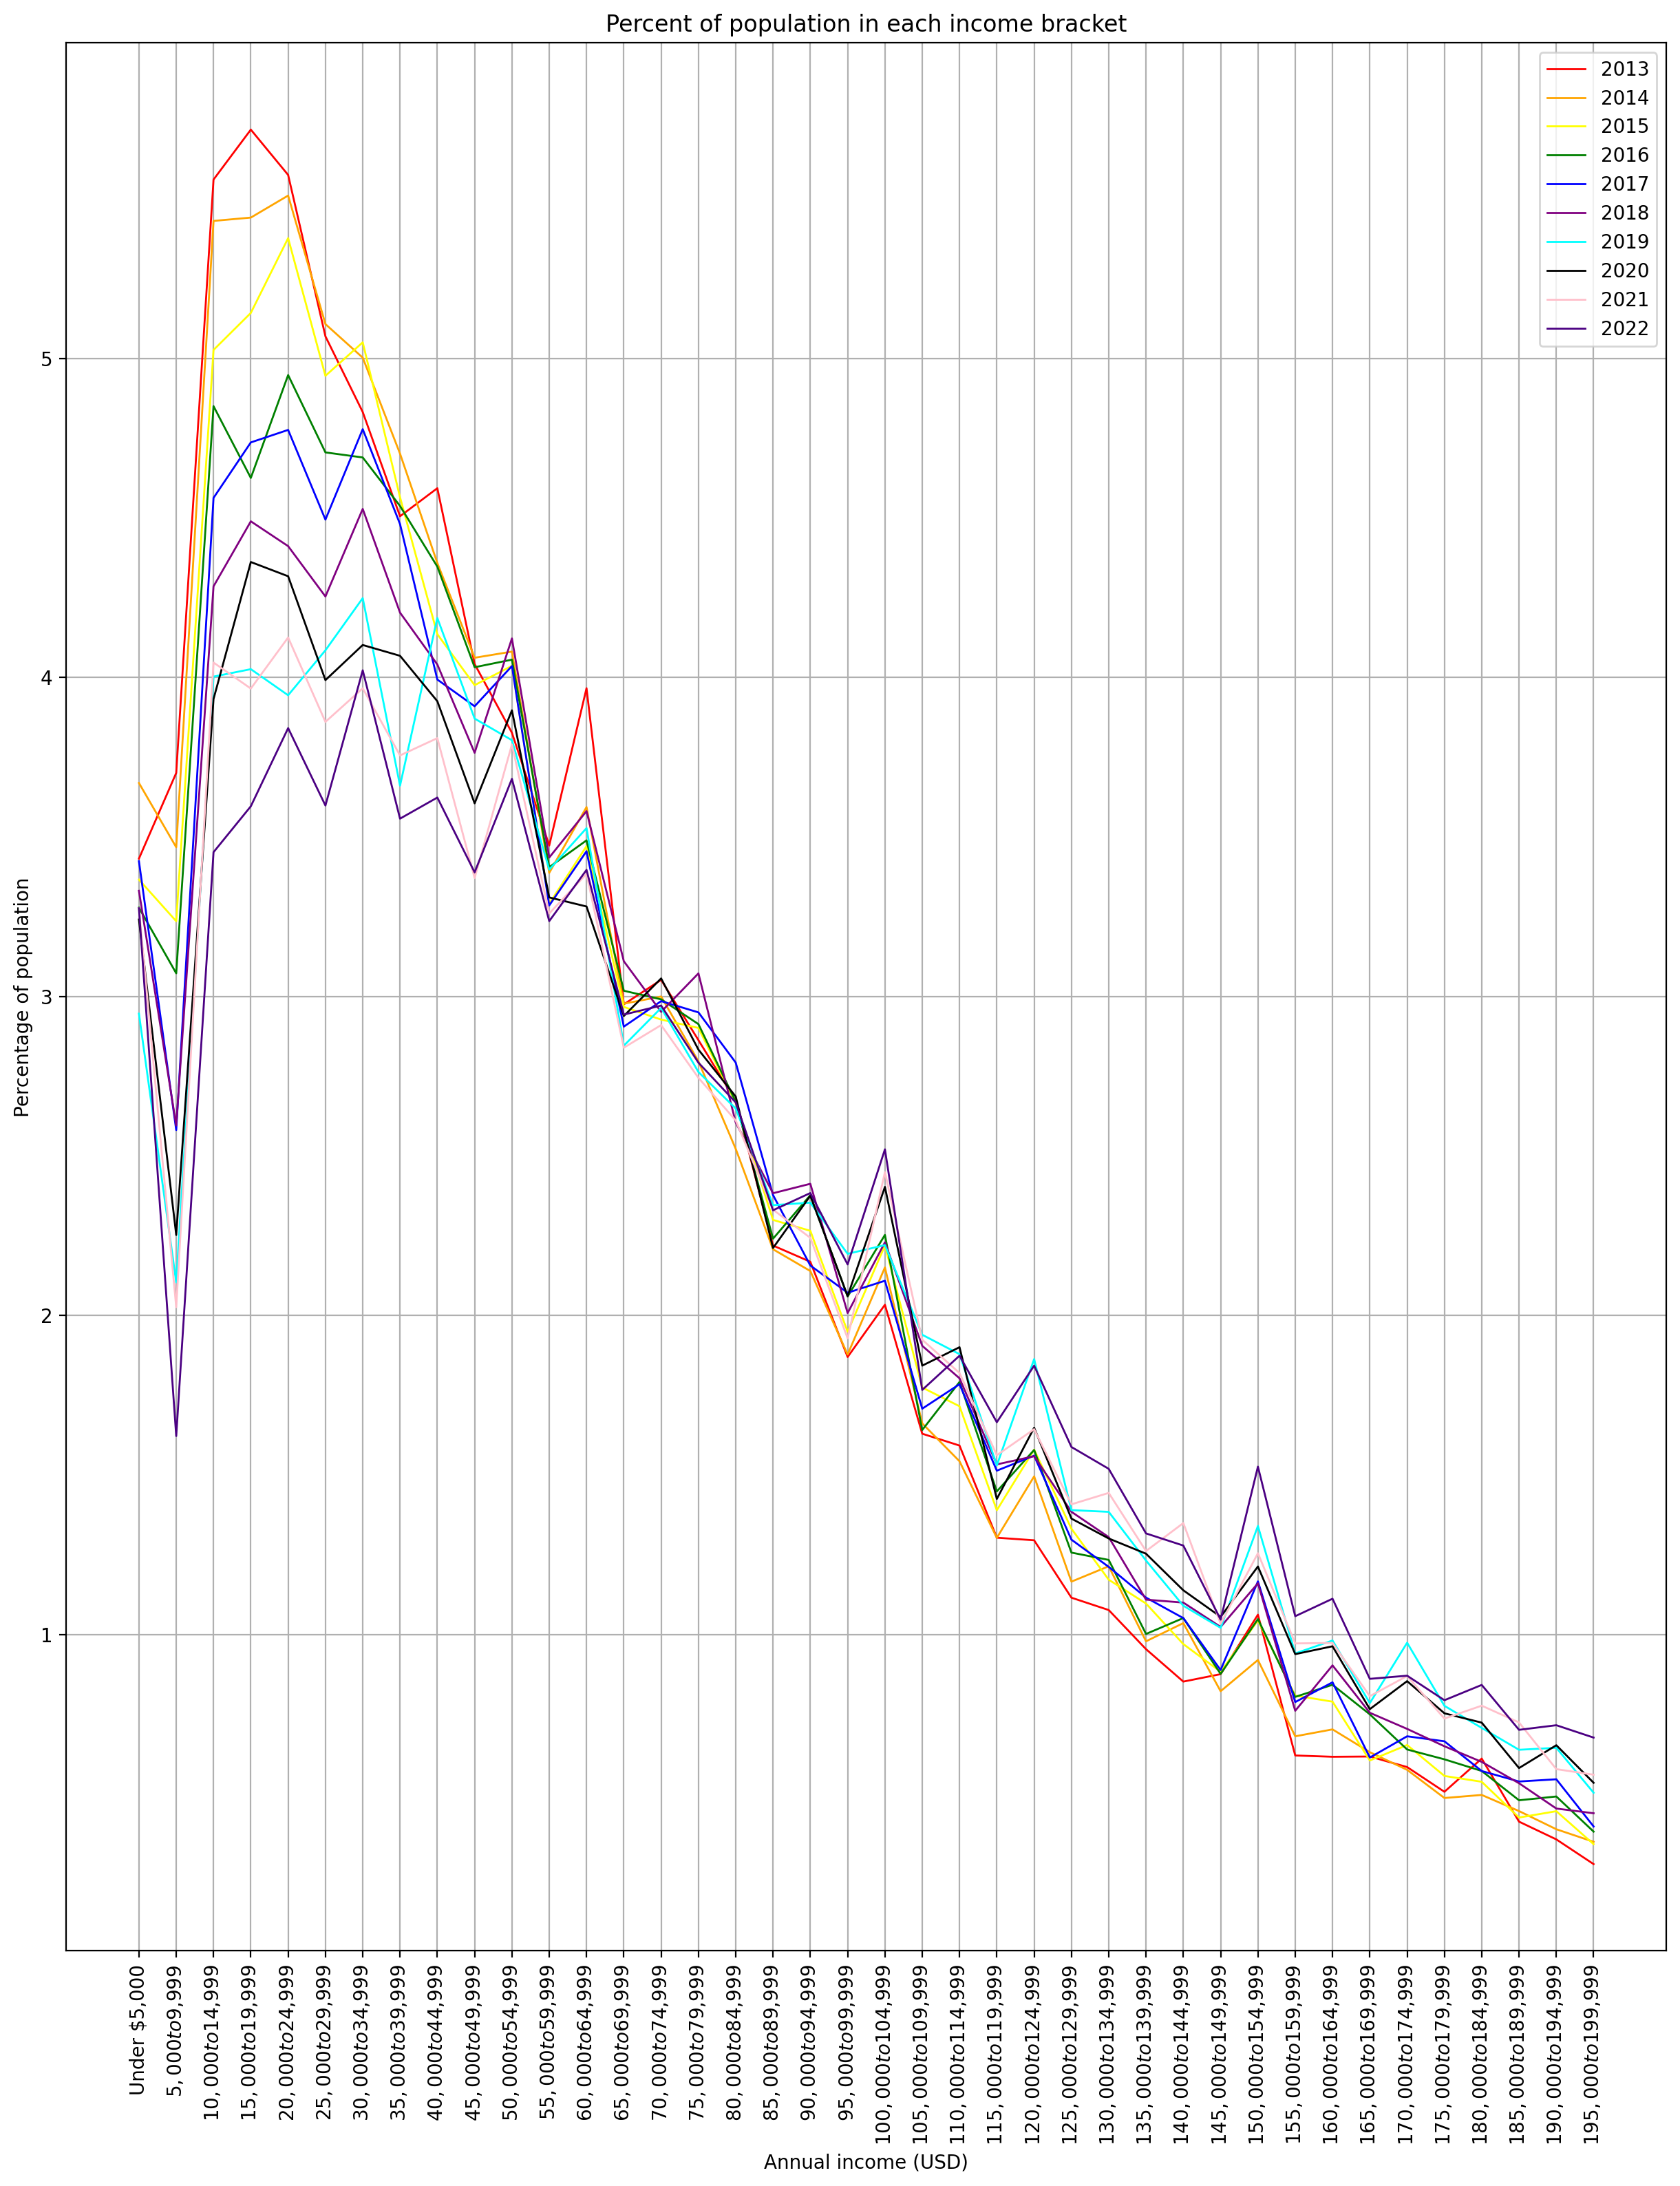

In [3]:
YEARS = list(range(2013,2023))
COLORS = ["red","orange","yellow","green","blue","purple","cyan","black","pink","indigo"]
print(YEARS)
plt.figure(dpi = 200, figsize= (15,18))

color_index = 0
for year in YEARS:

    yeardf = dataframes[year]

    #The columns that we need to convert to percent in order to compare accurately.
    to_percent_cols = yeardf.columns.values[2:42]

    #Remove all commas in between numbers.
    yeardf.replace({',': ""}, regex=True , inplace = True)



    yeardf["Total"] = yeardf["Total"].astype(float)


    #Turns each column of income bracket into the percent of each category that falls into the braket.
    for col in to_percent_cols:
        yeardf[col] = yeardf[col].astype(float)
        yeardf[col] = (yeardf[col]/ yeardf["Total"])* 100 
    
    plt.plot(to_percent_cols , list(yeardf.iloc[0][2:42]) , color = COLORS[color_index] , label = year , linewidth=1)
    
    color_index += 1


plt.xticks(rotation=90)
plt.title(f"Percent of population in each income bracket")
plt.xlabel("Annual income (USD)")
plt.ylabel("Percentage of population")
plt.grid()
plt.legend()
plt.savefig("vis1.png", bbox_inches="tight")
plt.show()



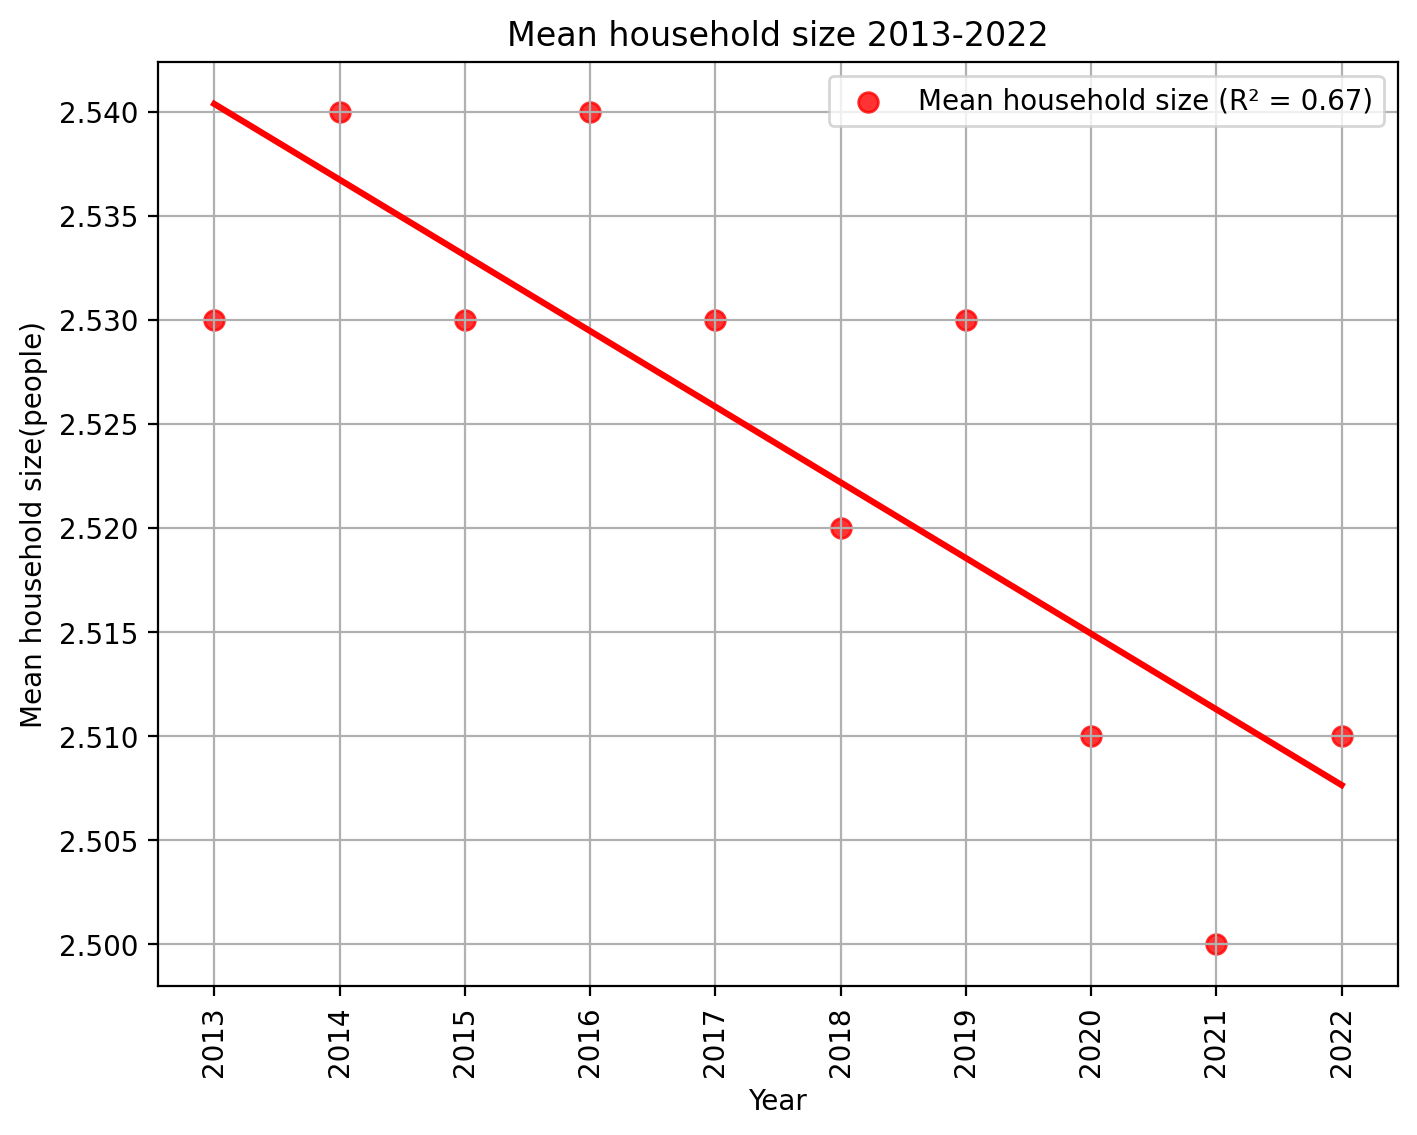

array([[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]])

In [23]:
YEARS = list(range(2013,2023))

color_index = 0

plt.figure(dpi = 200, figsize= (8,6))

overall_household_size = []

for year in YEARS:

    yeardf = dataframes[year]

    #The column where the mean sizes of household for each bracket is contained.
    size_household_row = yeardf.loc[yeardf["Characteristic"]=="Mean size of household"]
    
    #The column "Total" means overall mean household size, income level not considered.
    overall_household_size.append(size_household_row["Total"].iloc[0])

#plt.plot(YEARS , overall_household_size , color = "red" , label = "Mean household size" , linewidth=1)

def perform_linear_regression(X, y):
    '''
    Performs linear regression on the provided data and returns the
    model, predicted values, and R2 values.
       
    Parameters: 
    - X: independent variable
    - y: dependent variable
       
    Returns: 
    - model: the fitted LinearRegression model
    - y_pred = the predicted values based on the model
    - r2 = R2 value indicating goodness of fit.
    '''
    model = LinearRegression()
    model.fit(X, y)
    # Predict values and calculate r2
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    return model, y_pred, r2


# Perform linear regression to find r squared
model, y_pred, r2 = perform_linear_regression(np.array(YEARS).reshape(-1,1), np.array(overall_household_size).reshape(-1,1))

sns.regplot(x= YEARS, y= overall_household_size, 
            label=f'{"Mean household size"} (R² = {r2:.2f})', ci=None, 
            scatter_kws={"s": 50} , color = "red")


plt.xticks(YEARS , rotation=90)
plt.title(f"Mean household size 2013-2022")
plt.xlabel("Year")
plt.ylabel("Mean household size(people)")
plt.grid()
plt.legend()
plt.savefig("vis2.png", bbox_inches="tight")
plt.show()

np.array(YEARS).reshape(1,-1)

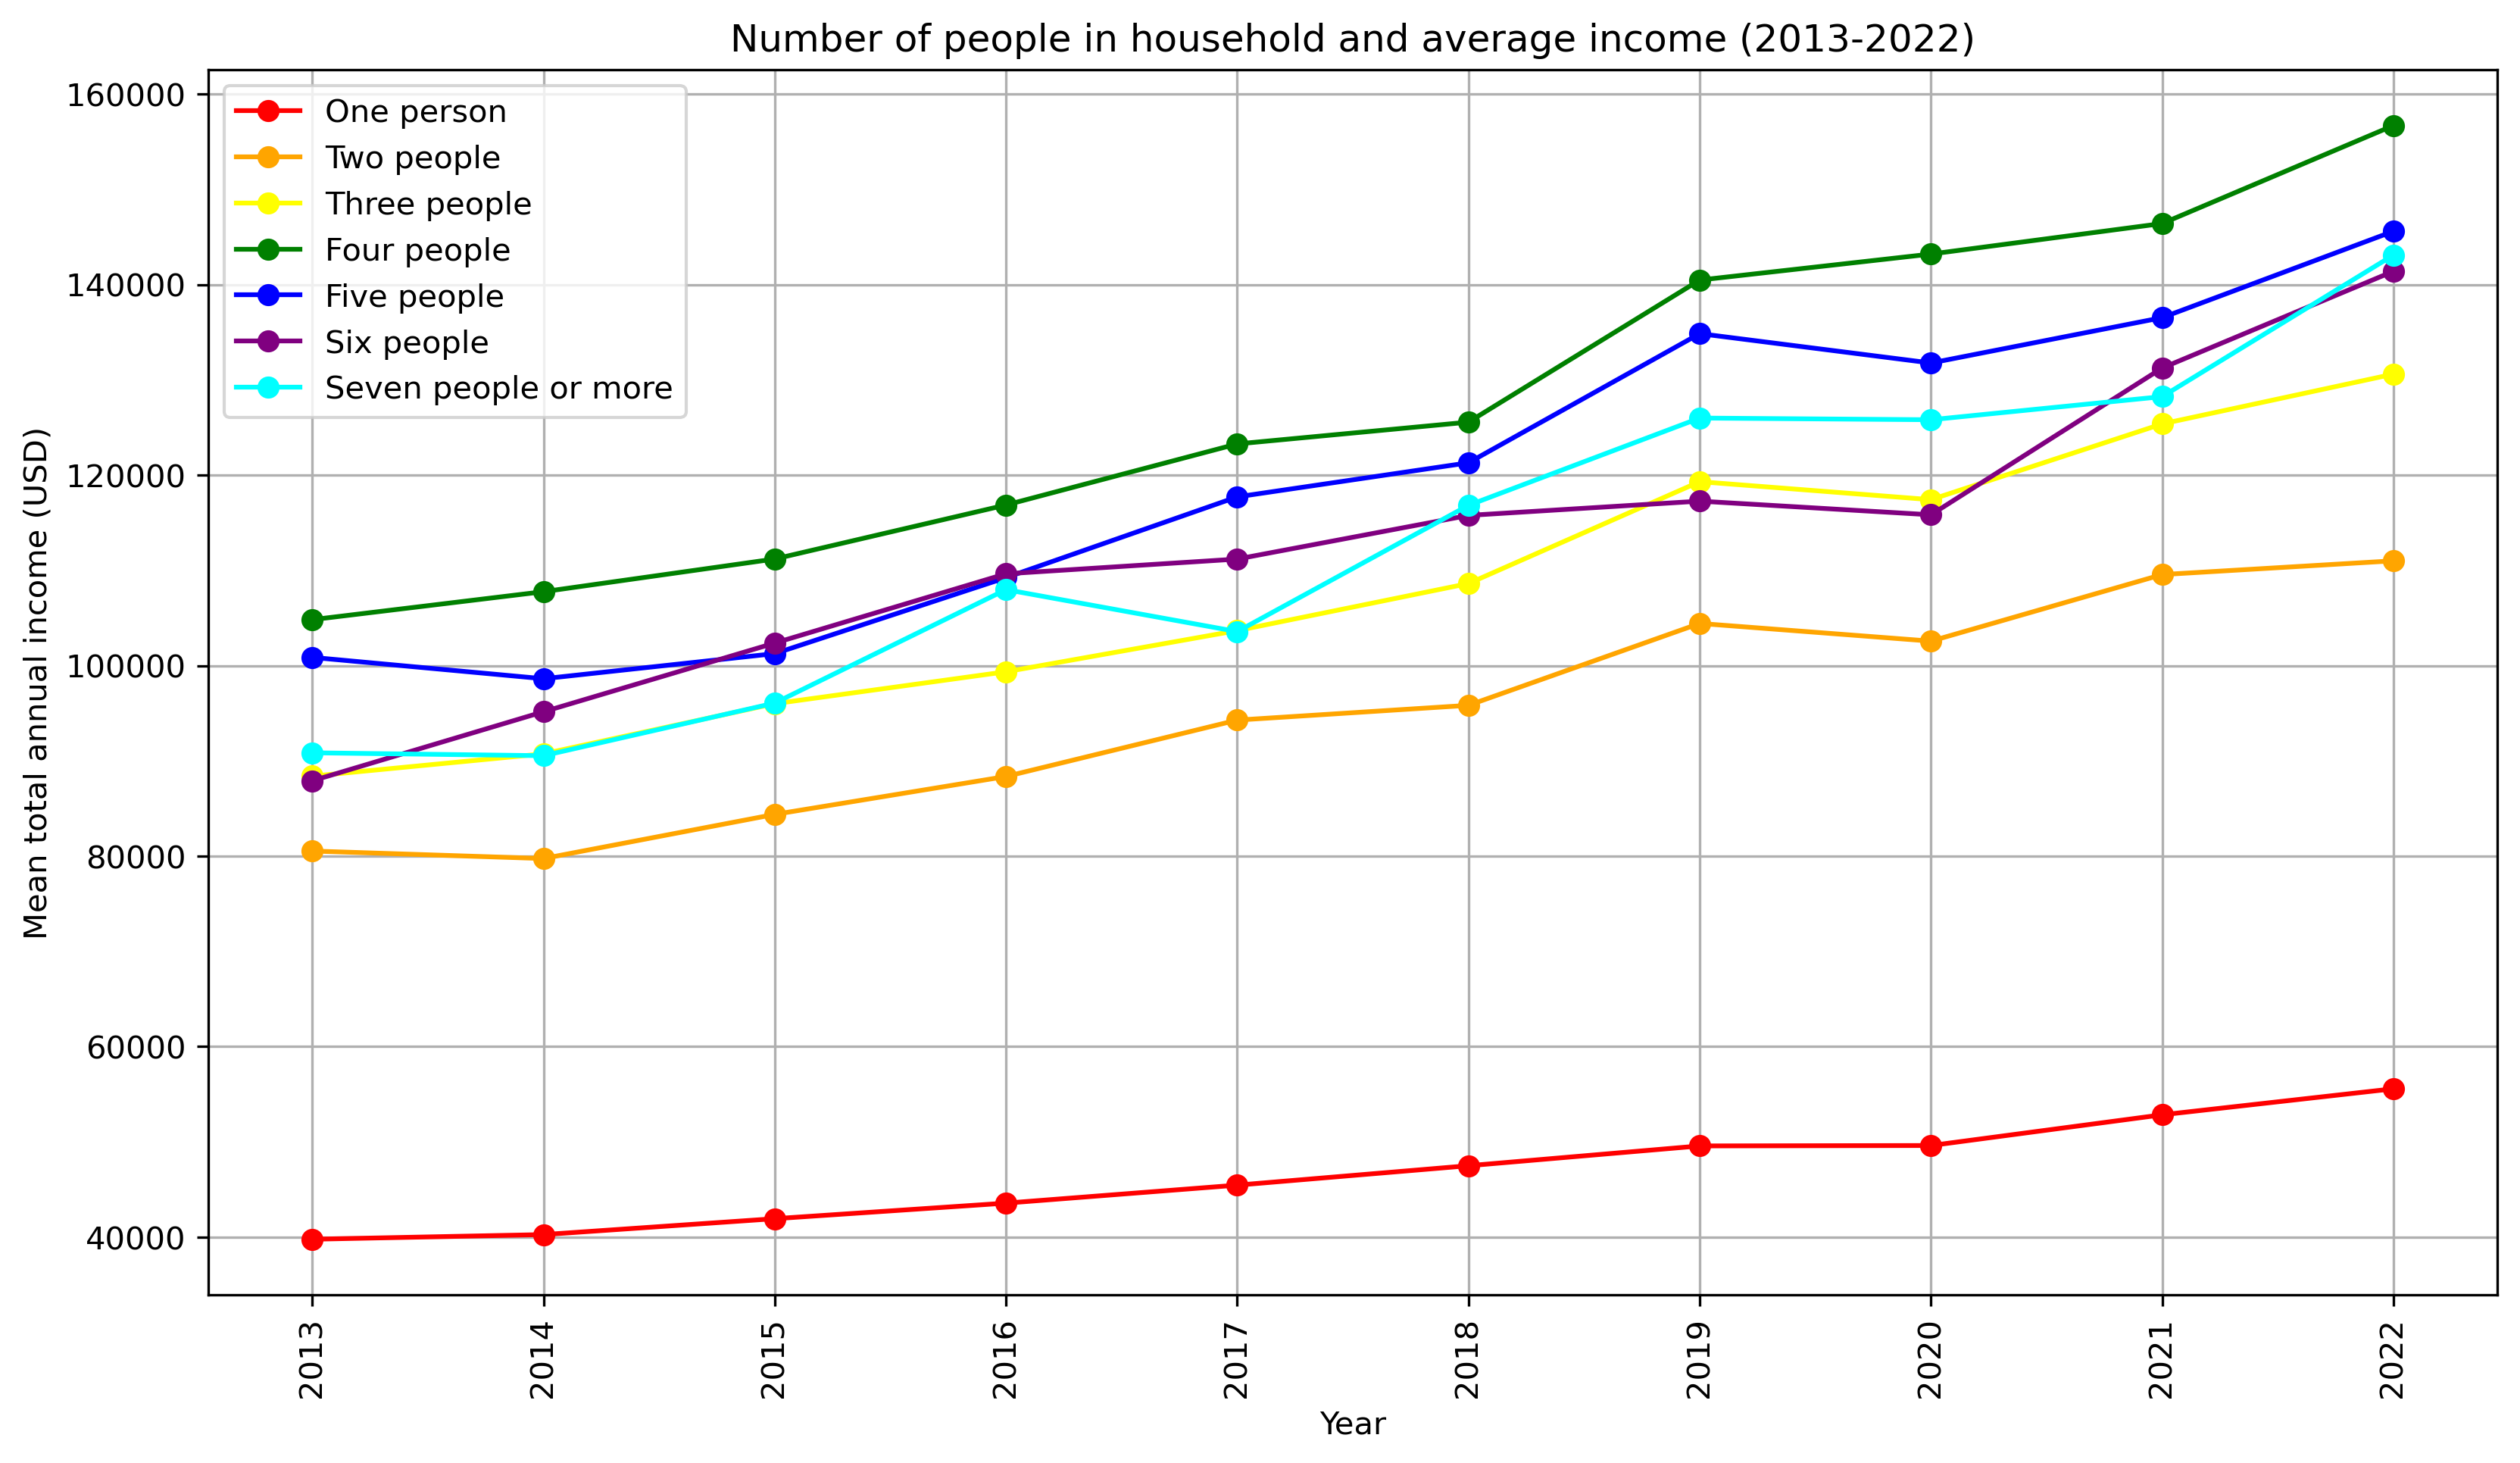

In [25]:
#x = years
#y = avg income for the size for the year
# lines = size of household

YEARS = list(range(2013,2023))
COLORS = ["red","orange","yellow","green","blue","purple","cyan","black","pink","indigo"]
SIZES = ["One person","Two people" ,"Three people" ,"Four people" ,"Five people", "Six people" ,"Seven people or more"]


plt.figure(dpi = 300, figsize= (13,7))

all_size_household_avginc = []

for year in YEARS:

    yeardf = dataframes[year]
    
    #Remove all commas in between numbers.(mean income column)
    yeardf.replace({',': ""}, regex=True , inplace = True)
    
    size_household_avginc = []
    
    for size in SIZES:
        #The columns that we need to examine
        size_household_avginc.append(yeardf.loc[yeardf["Characteristic"]== size ]["Mean income"].iloc[0])
    
        size_household_avginc = [float(i) for i in size_household_avginc]
    
    all_size_household_avginc.append(size_household_avginc)

#Transpose the array so each subarray value corresponds to each year
all_size_household_avginc = np.array(all_size_household_avginc)
all_size_household_avginc = np.transpose(all_size_household_avginc)

color_index = 0
size_index = 0

for y in all_size_household_avginc:
    plt.plot(YEARS , y , '-bo', color = COLORS[color_index] , label = SIZES[size_index] , linewidth=1.5)
    
    color_index += 1
    size_index += 1
    

plt.xticks(rotation=90)
plt.xticks(YEARS)
plt.title(f"Number of people in household and average income (2013-2022)")
plt.xlabel("Year")
plt.ylabel("Mean total annual income (USD)")
plt.grid()
plt.legend()
plt.savefig("vis3.png", bbox_inches="tight")
plt.show()


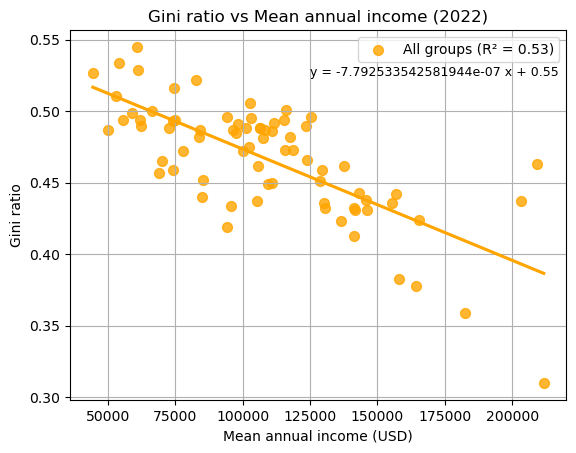

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

YEAR = 2022
df_year = dataframes[YEAR]

df_year_linreg = df_year[["Gini ratio" , "Mean income"]]

df_year_linreg = df_year_linreg.rename(columns={'Gini ratio': 'Gini_ratio', 'Mean income': 'Mean_income'})

df_year_linreg = df_year_linreg[df_year_linreg.Gini_ratio != "(X)"]
df_year_linreg = df_year_linreg[df_year_linreg.Mean_income != "(X)"]

df_year_linreg["Gini_ratio"] = df_year_linreg["Gini_ratio"].astype(float)
df_year_linreg["Mean_income"] = df_year_linreg["Mean_income"].astype(float)

x = np.array(df_year_linreg["Mean_income"]).reshape(-1, 1)
y = np.array(df_year_linreg["Gini_ratio"]).reshape(-1, 1)


def perform_linear_regression(X, y):
    '''
    Performs linear regression on the provided data and returns the
    model, predicted values, and R2 values.
       
    Parameters: 
    - X: independent variable
    - y: dependent variable
       
    Returns: 
    - model: the fitted LinearRegression model
    - y_pred = the predicted values based on the model
    - r2 = R2 value indicating goodness of fit.
    '''
    model = LinearRegression()
    model.fit(X, y)
    # Predict values and calculate r2
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    return model, y_pred, r2


# Perform linear regression
model, y_pred, r2 = perform_linear_regression(x, y)

# Plot data and regression line
sns.regplot(x='Mean_income', y='Gini_ratio', data=df_2022_linreg, 
            label=f'{"All groups"} (R² = {r2:.2f})', ci=None, 
            scatter_kws={"s": 50} , color = "orange")

equation = f"y = {float(model.coef_)} x + {round(float(model.intercept_),2)}"

plt.title(f"Gini ratio vs Mean annual income ({YEAR})")
plt.xlabel("Mean annual income (USD)")
plt.ylabel("Gini ratio")
plt.text(125000 ,0.525, equation , fontsize=9 , color = "black")
plt.legend()
plt.grid()
plt.savefig("vis4.png", bbox_inches="tight")
plt.show()
